In [70]:
import pandas as pd
import csv
import glob, os
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, sqrt, arctan
import numpy as np

filenames=glob.glob(r'C:\Users\Cheng Wen\Desktop\Year 4 Sem 2\FYP\Data\070322\2\*.csv')

#Read csv file and translate timestamp into time(us)
"""input: full path of filename & threshold value, outputs: dataframe"""
def prep_f(fn):
    df = pd.read_csv(fn,header=None,names=['amplitude','phase/rad'])
    frame_size, T = list(df.iloc[0])[:2]
    frame_size = int(frame_size.split(' ')[-1])
    T = float(T.split(' ')[-1])
    #immediately there is a problem: timestamp only has 0.1ms resolution - breaks when samples are 50us apart
    df = df.iloc[3:]
    df['t/us'] = np.linspace(0,T,frame_size)
    df = df.set_index('t/us').iloc[:-1]
    df = df.dropna(axis = 0, how = 'any') #drop nan row
    df = df.drop('timestamp',axis='columns') #redundant col
    df = df.applymap(lambda x: float(x)) #convert str to float
    #only consider values above certain threshold
    df = df[df['amplitude']>0.5*np.array(df['amplitude'])[-1]]
    return df

#Define Rabi sensitivity function
T = 1    #normalised units
d = 0.399343/T
pt = np.linspace(0, 1, 80000)
o = (pi/2) - arctan(2*T*d)
o3 = (pi*sqrt(1+(2*T*d)**2))*(pt/T)
o4 = (pi*sqrt(1+(2*T*d)**2))*((T-pt)/T)
g = (sin(o))**2 * cos(o) * ((1 - cos(o4))*sin(o3) + (1 - cos(o3))*sin(o4))
I = np.trapz(g, x=pt, axis = 0)

#Define differentiated Rabi sensitivity function
def sens(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20000:]))
    data = data.iloc[:300]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/80e-3), len(data))
    #Rabi sensitivity function
    o1 = (pi*sqrt(1+(2*T*d)**2))*(t/T)
    o2 = (pi*sqrt(1+(2*T*d)**2))*((T-t)/T)
    dg = ((2*pi*d)/(1+(2*T*d)**2)) * ((1 - cos(o2))*cos(o1) - (1 - cos(o1))*cos(o2))
    dp = -0.5*np.trapz(dg*df, x=t, axis = 0) #change in excitation probability
    dv = dp*9 #change in frequency
    #Plot graphs
    fig, [ax0,ax1] = plt.subplots(1,2,figsize=(16,5))
    ax0.title.set_text('Amplitude')
    ax1.title.set_text('Phase')
    ax0.set(xlabel="Time(ms)",ylabel="Amplitude")
    ax1.set(xlabel="Time(ms)",ylabel="Phase(rad)")
    ax0.plot(t*80,data['amplitude'])
    ax1.plot(t*80,data['phase/rad'])
    plt.show()
    return dp, dv

def ram(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20000:]))
    data = data.iloc[:300]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/80e-3), len(data))
    #Ramsey senstivity function
    ti = 20e-3
    td = 40e-3
    g1 = sin((pi/2)*(t/ti))
    dg1 = (pi/(2*ti))*cos((pi/2)*(t/ti))
    g2 = 1
    dg2 = 0
    g3 = sin((pi/2)*(t/ti))
    dg3 = (pi/(2*ti))*cos((pi/2)*(t/ti))
    I2 = td - (4/pi)*ti
    dp2 = -0.5*np.trapz((dg1+dg3)*df, x=t, axis = 0) #change in excitation probability
    dv2 = dp2*9 #change in frequency
    return dp2, dv2

def hram(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20000:]))
    data = data.iloc[:300]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/120e-3), len(data))
    #Hyper Ramsey senstivity function
    ti = 20e-3
    td = 80e-3
    g1 = sin((pi/2)*(t/ti))
    dg1 = (pi/(2*ti))*cos((pi/2)*(t/ti))
    g2 = 1
    dg2 = 0
    g3 = sin((pi/2)*(t-ti-td)/ti)
    dg3 = (pi/(2*ti))*cos((pi/2)*(t)/ti)
    g4 = -sin((pi/2)*(t-2*ti-td)/ti)
    dg4 = -(pi/(2*ti))*cos((pi/2)*(t)/ti)
    g5 = -sin((pi/2)*(t-3*ti-td)/ti)
    dg5 = -(pi/(2*ti))*cos((pi/2)*(t)/ti)
    I2 = td - (4/pi)*ti
    dp3 = -0.5*np.trapz((dg1+dg3+dg4+dg5)*df, x=t, axis = 0) #change in excitation probability
    dv3 = dp3*9 #change in frequency
    return dp3, dv3

for i in filenames:
    sep = "_"
    print(os.path.basename(i).split(sep, 1)[1], "Rabi (dp, dv) = ", sens(prep_f(i)), "Ramsey (dp, dv) = ", ram(prep_f(i)), "HRamsey (dp, dv) = ", hram(prep_f(i)))

ValueError: invalid literal for int() with base 10: '200000.000000'

In [2]:
def freq(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20000:]))
    data = data.iloc[:100]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/80e-3), len(data))
    o1 = (pi*sqrt(1+(2*T*d)**2))*(t/T)
    o2 = (pi*sqrt(1+(2*T*d)**2))*((T-t)/T)
    dg = ((2*pi*d)/(1+(2*T*d)**2)) * ((1 - cos(o2))*cos(o1) - (1 - cos(o1))*cos(o2))
    dp = -0.5*np.trapz(dg*df, x=t, axis = 0) #change in excitation probability
    dv = dp*(0.798685*pi/80e-3)/(353*10**12) #change in frequency
    return dv

#Plot frequency shift against attenuation
attn = list(reversed(range(11)))
v = []
for i in filenames:
    #sep = '_'
    #attn.append(os.path.basename(i).split(sep, 1)[0])
    v.append(freq(prep_f(i)))
    
fig=plt.figure(figsize=(10,6))
plt.plot(attn, v, "bx")
plt.title("Frequency Shift against Attentuation (Rabi)")
plt.xlabel('Attenuation (db)')
plt.ylabel('Frequency Shift (Hz)')
plt.show()

ValueError: Length of values (2000) does not match length of index (1999)

In [23]:
def freq2(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20000:]))
    data = data.iloc[:300]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/80e-3), len(data))
    #Ramsey senstivity function
    ti = 20e-3
    td = 40e-3
    g1 = sin((pi/2)*(t/ti))
    dg1 = (pi/(2*ti))*cos((pi/2)*(t/ti))
    g2 = 1
    dg2 = 0
    g3 = -sin((pi/2)*(t-2*ti-td)/ti)
    dg3 = -(pi/(2*ti))*cos((pi/2)*(t-2*ti-td/ti))
    dp2 = -0.5*np.trapz((dg1+dg3)*df, x=t, axis = 0) #change in excitation probability
    dv2 = (dp2*(pi/80e-3))/(353*10**12) #change in frequency
    return dv2

#Plot frequency shift against attenuation
attn2 = list(reversed(range(11)))
v2 = []
for i in filenames:
    #sep = '_'
    #attn.append(os.path.basename(i).split(sep, 1)[0])
    v2.append(freq2(prep_f(i)))
    
fig=plt.figure(figsize=(10,6))
plt.plot(attn2, v2, "bx")
plt.title("Frequency Shift against Attentuation (Ramsey)")
plt.xlabel('Attenuation (db)')
plt.ylabel('Frequency Shift (Hz)')
plt.show()

ValueError: Length of values (2000) does not match length of index (1999)

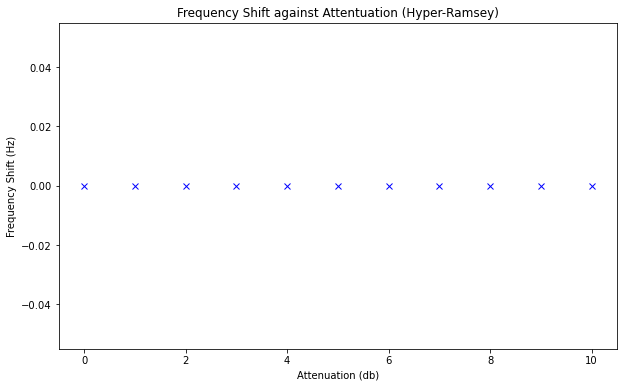

In [51]:
def freq3(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20000:]))
    data = data.iloc[:300]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/55e-3), len(data))
    #Hyper-Ramsey senstivity function
    ti = 5e-3
    td = 45e-3
    g1 = sin((pi/2)*(t/ti))
    dg1 = (pi/(2*ti))*cos((pi/2)*(t/ti))
    g2 = 1
    dg2 = 0
    g3 = sin((pi/2)*(t)/ti)
    dg3 = (pi/(2*ti))*cos((pi/2)*(t/ti))
    g4 = -sin((pi/2)*(t)/ti)
    dg4 = -(pi/(2*ti))*cos((pi/2)*(t/ti))
    g5 = -sin((pi/2)*(t)/ti)
    dg5 = -(pi/(2*ti))*cos((pi/2)*(t/ti))
    dp3 = -0.5*np.trapz((dg1+dg3+dg4+dg5)*df, x=t, axis = 0) #change in excitation probability
    dv3 = (dp3*9)/(353*10**12) #change in frequency
    return dv3

#Plot frequency shift against attenuation
attn3 = list(reversed(range(11)))
v3 = []
for i in filenames:
    #sep = '_'
    #attn.append(os.path.basename(i).split(sep, 1)[0])
    v3.append(freq3(prep_f(i)))
    
fig=plt.figure(figsize=(10,6))
plt.plot(attn3, v3, "bx")
plt.title("Frequency Shift against Attentuation (Hyper-Ramsey)")
plt.xlabel('Attenuation (db)')
plt.ylabel('Frequency Shift (Hz)')
plt.show()

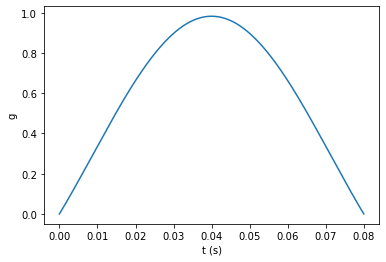

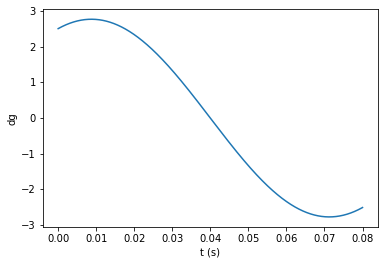

In [36]:
t = np.linspace(0, 80e-3, 80000)
T = 1
o = (pi/2) - arctan(2*T*d)
o1 = (pi*sqrt(1+(2*T*d)**2))*(pt/T)
o2 = (pi*sqrt(1+(2*T*d)**2))*((T-pt)/T)
o3 = (pi*sqrt(1+(2*T*d)**2))*(pt/T)
o4 = (pi*sqrt(1+(2*T*d)**2))*((T-pt)/T)
g = (sin(o))**2 * cos(o) * ((1 - cos(o4))*sin(o3) + (1 - cos(o3))*sin(o4))
dg = ((2*pi*d)/(1+(2*T*d)**2)) * ((1 - cos(o2))*cos(o1) - (1 - cos(o1))*cos(o2))

plt.plot(t, g)
plt.ylabel("g");plt.xlabel("t (s)")
plt.show()

plt.plot(t, dg)
plt.ylabel("dg");plt.xlabel("t (s)")
plt.show()

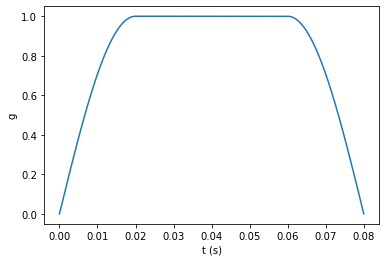

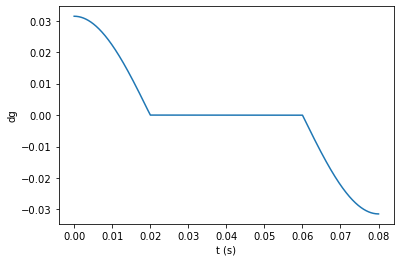

In [11]:
t = np.linspace(0, 80e-3, 80000)
ti = 20e-3
td = 40e-3
T = 1
def f(x):
    if x <= 20e-3:
        return sin((pi/2)*(x/ti))
    if 20e-3 < x < 60e-3:
        return 1
    else:
        return cos((pi/2)*((x-ti-td)/ti))
    
def df(x):
    if x <= 20e-3:
        return (pi/2*ti)*cos((pi/2)*(x/ti))
    if 20e-3 < x < 60e-3:
        return 0
    else:
        return -(pi/2*ti)*sin((pi/2)*((x-ti-td)/ti))

f2 = np.vectorize(f)
f3 = np.vectorize(df)

plt.plot(t, f2(t))
plt.ylabel("g");plt.xlabel("t (s)")
plt.show()

plt.plot(t, f3(t))
plt.ylabel("dg");plt.xlabel("t (s)")
plt.show()

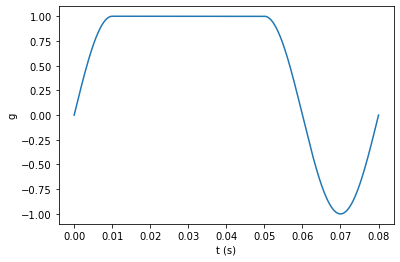

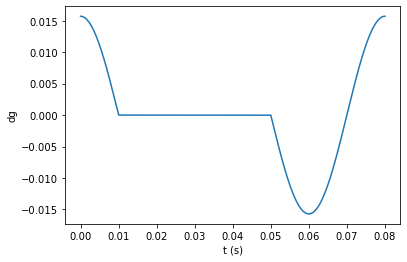

In [10]:
t = np.linspace(0, 80e-3, 80000)
ti = 10e-3
td = 40e-3
T = 1
def f(x):
    if x <= 10e-3:
        return sin((pi/2)*(x/ti))
    if 10e-3 < x < 50e-3:
        return 1
    if 50e-3 < x < 60e-3:
        return cos((pi/2)*((x-ti-td)/ti))
    if 60e-3 < x < 70e-3:
        return -sin((pi/2)*((x-2*ti-td)/ti))
    if 70e-3 < x < 80e-3:
        return -cos((pi/2)*((x-3*ti-td)/ti))
    
def df(x):
    if x <= 10e-3:
        return (pi/2*ti)*cos((pi/2)*(x/ti))
    if 10e-3 < x < 50e-3:
        return 0
    if 50e-3 < x < 60e-3:
        return -(pi/2*ti)*sin((pi/2)*((x-ti-td)/ti))
    if 60e-3 < x < 70e-3:
        return -(pi/2*ti)*cos((pi/2)*((x-2*ti-td)/ti))
    if 70e-3 < x < 80e-3:
        return (pi/2*ti)*sin((pi/2)*((x-3*ti-td)/ti)) 

f2 = np.vectorize(f)
f3 = np.vectorize(df)

plt.plot(t, f2(t))
plt.ylabel("g");plt.xlabel("t (s)")
plt.show()

plt.plot(t, f3(t))
plt.ylabel("dg");plt.xlabel("t (s)")
plt.show()